# Drive and git setup

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/repos/GL-PS
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/repos/GL-PS
modeling/  notebooks/  README.md  src/  test.txt


# Flux-ratios pipeline modeling tests

In [7]:
!nvidia-smi

#import gigalens
!pip install corner
!pip install lenstronomy==1.13.2
!pip install gigalens --no-deps

Tue Dec 23 19:54:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             48W /  400W |     493MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [10]:
import sys
# import modeling functions
from importlib import reload
import src.flux_ratios_pipeline_funcs
reload(src.flux_ratios_pipeline_funcs)
from src.flux_ratios_pipeline_funcs import *

import matplotlib.pyplot as plt
# import gigalens functions
from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import sis, shear, epl, sie
from tensorflow_probability import distributions as tfd, bijectors as tfb

## Breaking up simulation tests

Setting up the truth

In [33]:
# truth configuration list
truth = [
    [ # mass distribution
        {'theta_E': 0.167, 'gamma': 2.013, 'e1': 0.049, 'e2': 0.083, 'center_x': 0.005, 'center_y': 0.011},
        {'gamma1': 0.078, 'gamma2': 0.015}  # external shear
    ],
    [ # lensing galaxy light
        {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.005, 'Ie': 250.055}
    ],
    [ # source light
        {'center_x': 0.004, 'center_y': 0.009, 'Ie': 2815.973}
    ]
]
# Physical model:
phys_model = PhysicalModel(
    [ # mass profile
        epl.EPL(50),
        shear.Shear()
    ],
    [ # lens light
        sersic.SersicEllipse(),
    ],
    [ # source light (Point() defined in functions)
        Point()
    ]
)

Defining different lens priors:
- Normal distributions
- truncated normals for eccentricities, positions and $\gamma$
- Uniform distribution for all parameters

In [34]:

lens_prior = tfd.JointDistributionSequential(
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
          e1=tfd.Normal(0, 0.1),
          e2=tfd.Normal(0, 0.1),
          center_x=tfd.Normal(0, 0.1),
          center_y=tfd.Normal(0, 0.1),
          )),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.Normal(0, 0.1),
           gamma2=tfd.Normal(0, 0.1),
          ),),])

lens_prior_trunc_normal = tfd.JointDistributionSequential(
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
          e1=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          e2=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          center_x=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          center_y=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          )),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
           gamma2=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          ),),])

lens_prior_uniform = tfd.JointDistributionSequential(
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          gamma=tfd.Uniform(1., 2.8,),
          e1=tfd.Uniform(-0.1, 0.1),
          e2=tfd.Uniform(-0.1, 0.1),
          center_x=tfd.Uniform(-0.1, 0.1),
          center_y=tfd.Uniform(-0.1, 0.1),
          )),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.Uniform(-0.1, 0.1),
           gamma2=tfd.Uniform(-0.1, 0.1),
          ),),])

Choosing a prior, creating the probabilistic model

In [42]:
lens_prior_chosen = lens_prior_uniform
prior = tfd.JointDistributionSequential(
    # truncated normal
    [lens_prior_chosen,]
)
# resolution
delta_pix = 0.0006
supersample = 1
num_pix = 750
# prob model without observed image
prob_model = ForwardProbModel(prior, 0, background_rms=0.2, exp_time=100)
# example of sampling from the prob model
example = lens_prior_chosen.sample(seed = 0)
size = int(tf.size(tf.nest.flatten(example)))
# kernel = np.load('/content/drive/MyDrive/point-source-updates/F475W-epsf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

Text(0.5, 1.0, 'image difference')

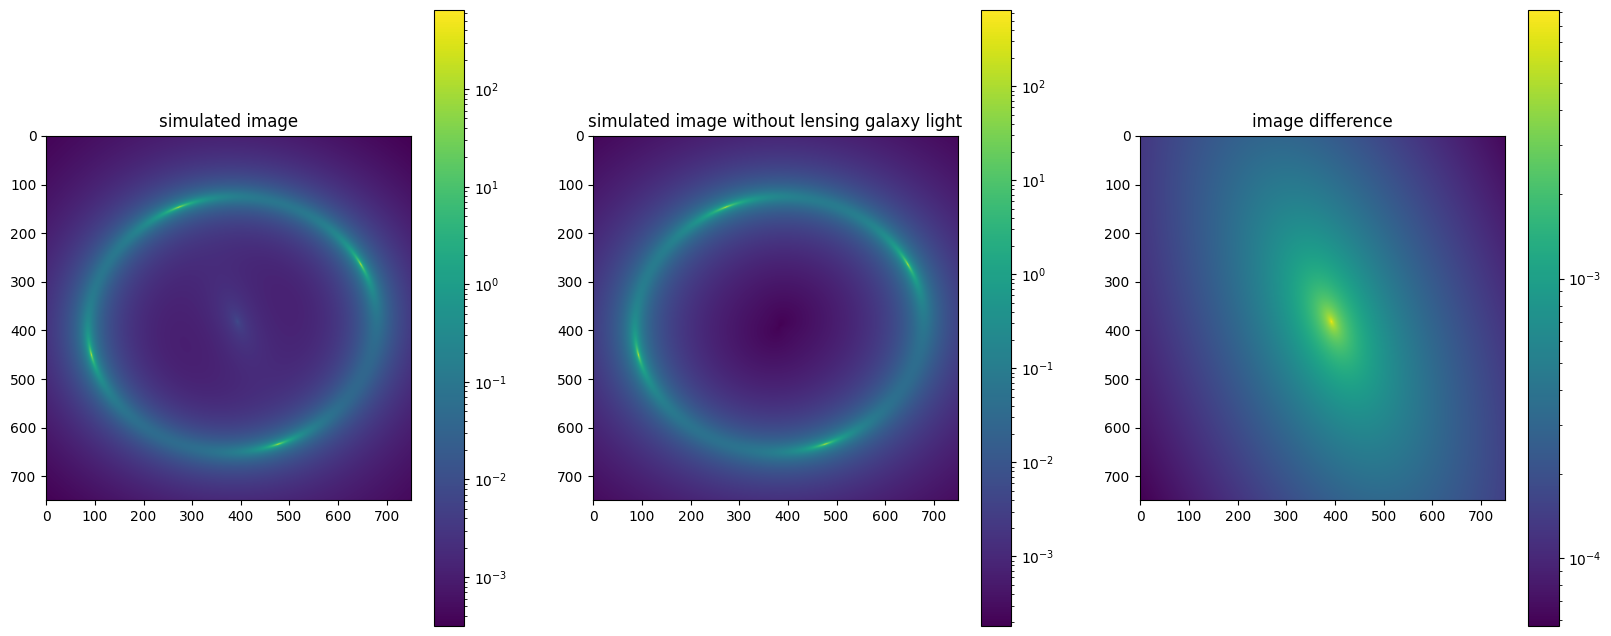

In [43]:
# simulated image with everything
sim_image = lens_sim.simulate(truth)
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
im = ax[0].imshow(sim_image, norm = 'log')#, vmin=0, vmax=10)
plt.colorbar(im, ax = ax[0])
ax[0].set_title("simulated image")
# simulated image without lensing galaxy light
lens_omitted_img= lens_sim.simulate([truth[0],[],truth[2]])
im = ax[1].imshow(lens_omitted_img, norm = 'log')#, vmin=0, vmax=10)
plt.colorbar(im, ax = ax[1])
ax[1].set_title("simulated image without lensing galaxy light")
#image difference
im = ax[2].imshow(sim_image - lens_omitted_img, norm='log')#, vmin=-10, vmax=10)
plt.colorbar(im, ax = ax[2])
ax[2].set_title("image difference")

Locating images with Brightest Points method

Brighest points reshaped into x, y:

x pixels: tf.Tensor([ 93 272 647 476], shape=(4,), dtype=int32)
x arcsec: tf.Tensor(
[[-0.1689    ]
 [-0.0615    ]
 [ 0.16350001]
 [ 0.06090001]], shape=(4, 1), dtype=float32)

y pixels: tf.Tensor([451 148 266 635], shape=(4,), dtype=int32)
y arcsec: tf.Tensor(
[[ 0.04590001]
 [-0.1359    ]
 [-0.0651    ]
 [ 0.15630001]], shape=(4, 1), dtype=float32)


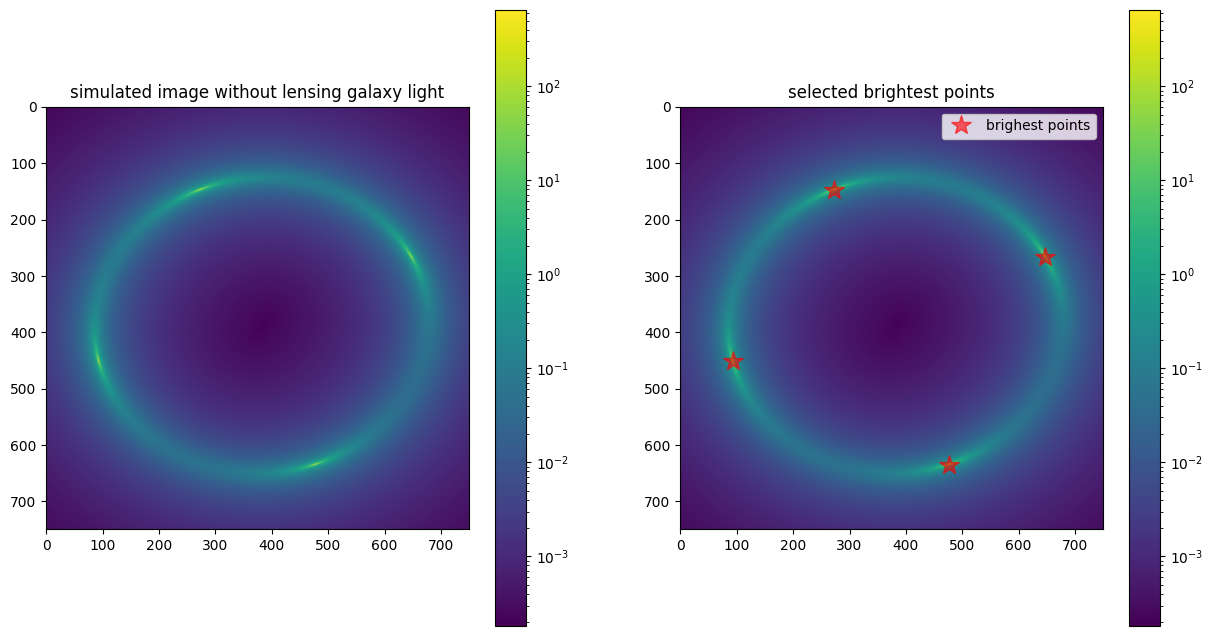

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
im = ax[0].imshow(lens_omitted_img, norm = 'log')#, vmin=0, vmax=10)
plt.colorbar(im, ax = ax[0])
ax[0].set_title("simulated image without lensing galaxy light")
im = ax[1].imshow(lens_omitted_img, norm = 'log')#, vmin=0, vmax=10)
plt.colorbar(im, ax = ax[1])

# locating images
converter = BrightestPoints(number_of_images = 4, num_pixels=num_pix, grid_size=int(num_pix/2), delta_pix=delta_pix, supersample=1)
brightest_pixels = converter.find_brightest_points(lens_omitted_img)
ax[1].plot(brightest_pixels[:, 1], brightest_pixels[:, 0], "*", ms = 15, color = "red", alpha = 0.6, label = "brighest points")
ax[1].set_title("selected brightest points")
ax[1].legend()
x_arcsec, y_arcsec = converter.pix_to_arcsec(brightest_pixels)
chains = 1
x = tf.repeat(x_arcsec[..., tf.newaxis], [chains], axis=-1)
y = tf.repeat(y_arcsec[..., tf.newaxis], [chains], axis=-1)
print("Brighest points reshaped into x, y:")
print("\nx pixels:", brightest_pixels[:,1])
print("x arcsec:", x)
print("\ny pixels:", brightest_pixels[:,0])
print("y arcsec:", y)

## Model test 1

In [13]:
lens_prior = tfd.JointDistributionSequential( #UNIFORM PRIOR
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
           # gamma=tfd.Uniform(1.8, 2.3,),
           # gamma=tfd.Uniform(1.5, 2.5,),
           # gamma=tfd.Uniform(1., 3.,),
          gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
           # e1=tfd.Uniform(-0.2, 0.2),
           # e2=tfd.Uniform(-0.2, 0.2),
          e1=tfd.Normal(0, 0.1),
          e2=tfd.Normal(0, 0.1),
          #  e1=tfd.Uniform(-0.2, 0.2),
          #  e2=tfd.Uniform(-0.2, 0.2),
          center_x=tfd.Normal(0, 0.1),
          center_y=tfd.Normal(0, 0.1),
           # center_x=tfd.Uniform(-0.2, 0.2),
           # center_y=tfd.Uniform(-0.2, 0.2),
          )
      ),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.Normal(0, 0.1),
           gamma2=tfd.Normal(0, 0.1),
          # gamma1=tfd.Uniform(-0.2, 0.2),
          # gamma2=tfd.Uniform(-0.2, 0.2),
          ),
       ),
  ]
  )


#prior = tfd.JointDistributionSequential(
#    [lens_prior,]
#)


#prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)

#example = lens_prior.sample(seed = 0)
#size = int(tf.size(tf.nest.flatten(example)))


Simulated image and brightest points:


-simulation-


  0%|          | 0/3000 [00:00<?, ?it/s]


--------- simulation. comparing flux ratios difference ----------

Best parameters:
 [{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.14972423], dtype=float32)>, 'gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.9859055], dtype=float32)>, 'e2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00674349], dtype=float32)>, 'e1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01464462], dtype=float32)>, 'center_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.02497563], dtype=float32)>, 'center_x': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.01936913], dtype=float32)>}, {'gamma2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.05096333], dtype=float32)>, 'gamma1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0086901], dtype=float32)>}]


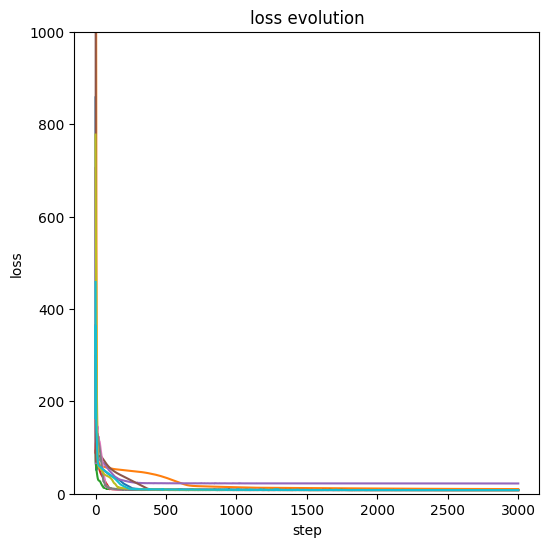


Relative errors:

theta_E: 0.18%
gamma: 4.52%
e1: 49.50%
e2: 112.72%
center_x: 3.15%
center_y: 0.10%
gamma1: 27.58%
gamma2: 103.85%




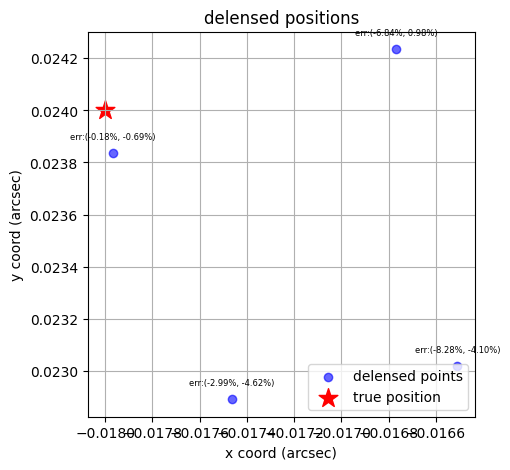


results when only the distance term is included in the loss with no prior --------------------------------------------------



  0%|          | 0/3000 [00:00<?, ?it/s]


Best parameters (only distance term):
 [{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.76899374], dtype=float32)>, 'gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9999647], dtype=float32)>, 'e2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.08520569], dtype=float32)>, 'e1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01300317], dtype=float32)>, 'center_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.18086827], dtype=float32)>, 'center_x': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.21431182], dtype=float32)>}, {'gamma2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.08518056], dtype=float32)>, 'gamma1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01298588], dtype=float32)>}]

Relative errors:

theta_E: 412.66%
gamma: 47.37%
e1: 55.16%
e2: 260.77%
center_x: 1171.56%
center_y: 823.47%
gamma1: 8.22%
gamma2: 240.72%




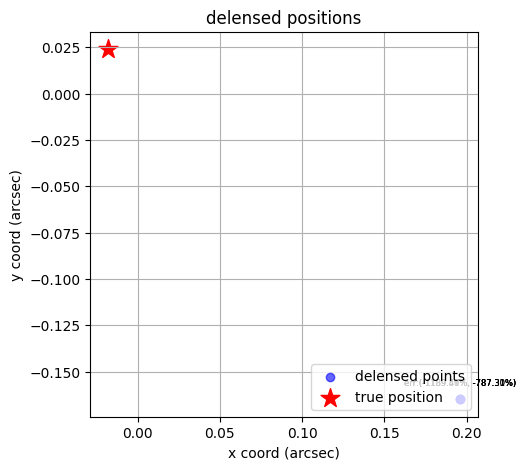


-simulation-

--------- simulation. comparing flux ratios difference ----------


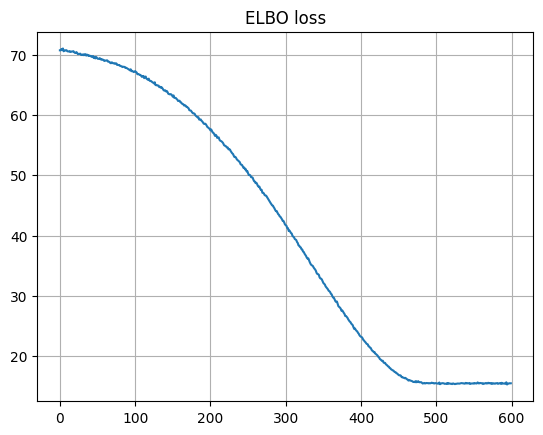


-simulation-

--------- simulation. comparing flux ratios difference ----------

----------------method: adaptative------------------



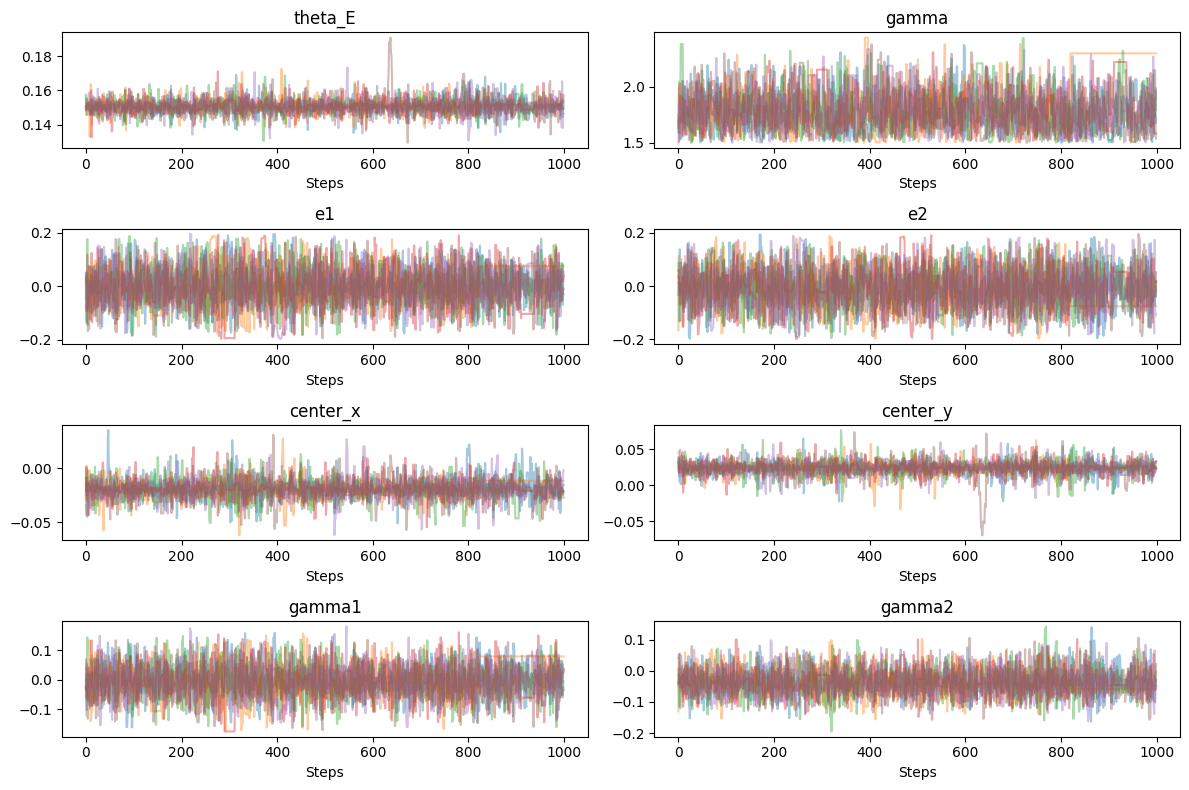


Rhat:
theta_E: 1.000217
gamma: 1.004569
e2: 1.002676
e1: 1.003599
center_y: 1.000595
center_x: 1.001146
gamma2: 1.001333
gamma1: 1.002728

ESS:
theta_E: 35675.339844
gamma: 7545.957031
e2: 15668.462891
e1: 11785.979492
center_y: 33899.777344
center_x: 29475.320312
gamma2: 26344.919922
gamma1: 14994.252930


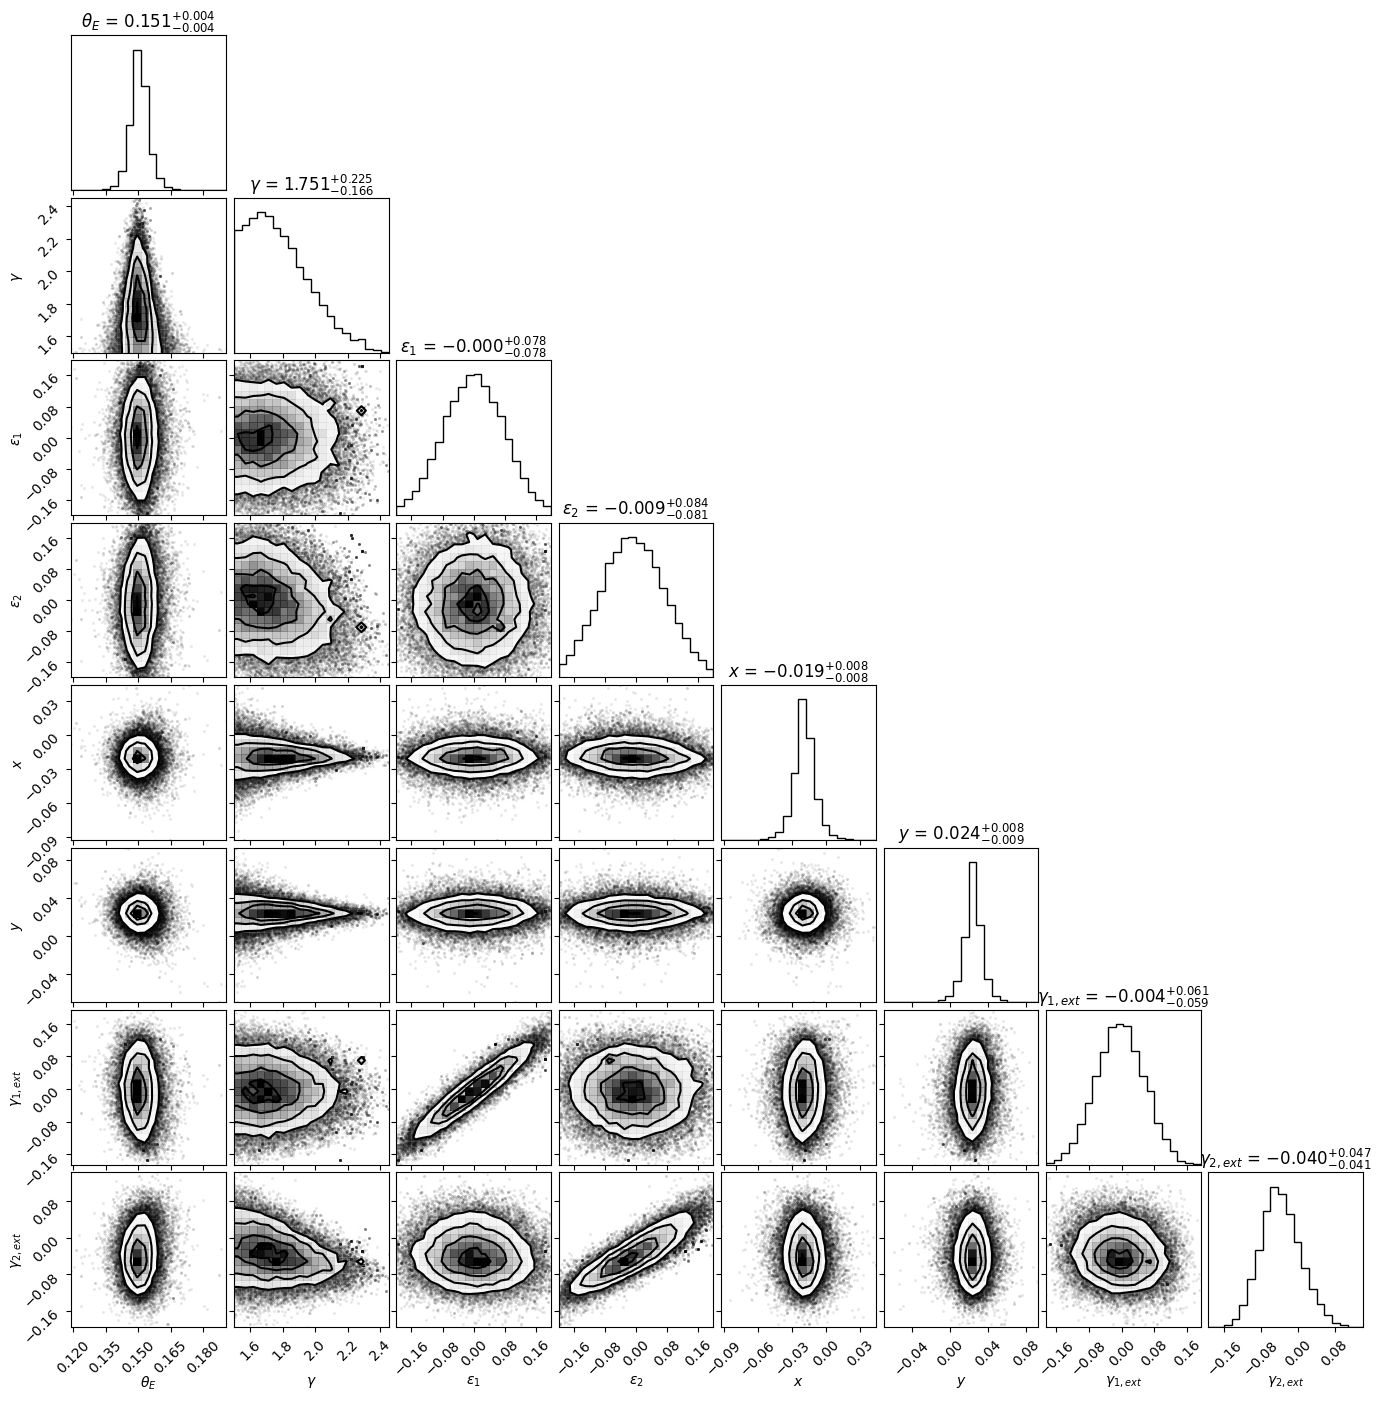

Parameter Means and Medians:
theta_E: mean = 0.151, median = 0.151
gamma: mean = 1.779, median = 1.751
e1: mean = -0.000, median = -0.000
e2: mean = -0.008, median = -0.009
center_x: mean = -0.019, median = -0.019
center_y: mean = 0.024, median = 0.024
gamma1: mean = -0.004, median = -0.004
gamma2: mean = -0.037, median = -0.040


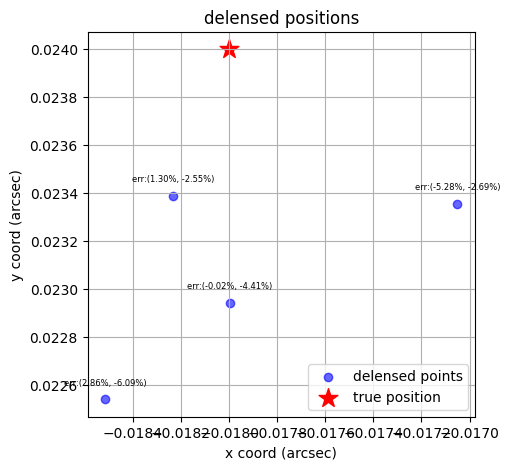

self.prob_model_output [{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.15050796], dtype=float32)>, 'gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7506909], dtype=float32)>, 'e2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00891688], dtype=float32)>, 'e1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00013828], dtype=float32)>, 'center_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.02426597], dtype=float32)>, 'center_x': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.0194246], dtype=float32)>}, {'gamma2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.03979609], dtype=float32)>, 'gamma1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.0042058], dtype=float32)>}]


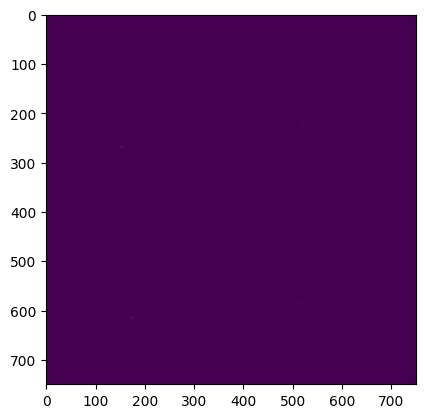

tf.Tensor(
[[0.00027204 0.00027334 0.00027458 ... 0.00028606 0.0002847  0.00028335]
 [0.00027353 0.00027477 0.00027609 ... 0.00028743 0.00028606 0.0002847 ]
 [0.00027497 0.00027628 0.0002776  ... 0.0002888  0.00028743 0.00028606]
 ...
 [0.0006404  0.00064484 0.00064947 ... 0.00030117 0.00029946 0.00029775]
 [0.00063614 0.00064055 0.00064515 ... 0.00029974 0.00029803 0.0002964 ]
 [0.00063176 0.00063629 0.00064086 ... 0.00029832 0.00029669 0.00029499]], shape=(750, 750), dtype=float32)
Brighest points reshaped into x, y:

x: tf.Tensor(
[[-0.1329    ]
 [-0.1209    ]
 [ 0.08130001]
 [ 0.08730001]], shape=(4, 1), dtype=float32)

y: tf.Tensor(
[[-0.0633    ]
 [ 0.14430001]
 [ 0.12690002]
 [-0.0933    ]], shape=(4, 1), dtype=float32)

params [{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.15050796], dtype=float32)>, 'gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7506909], dtype=float32)>, 'e2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00891688]

/content/drive/MyDrive/repos/GL-PS/src/flux_ratios_pipeline_funcs.py:1011: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


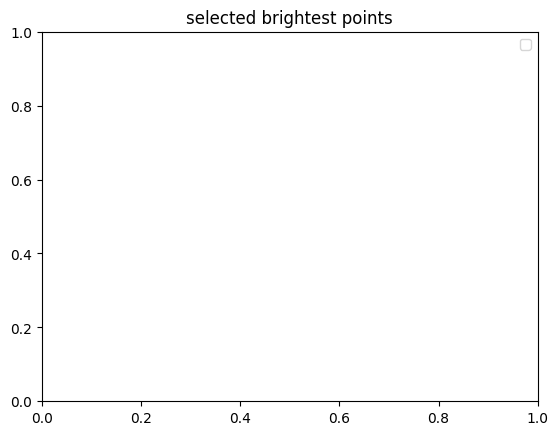

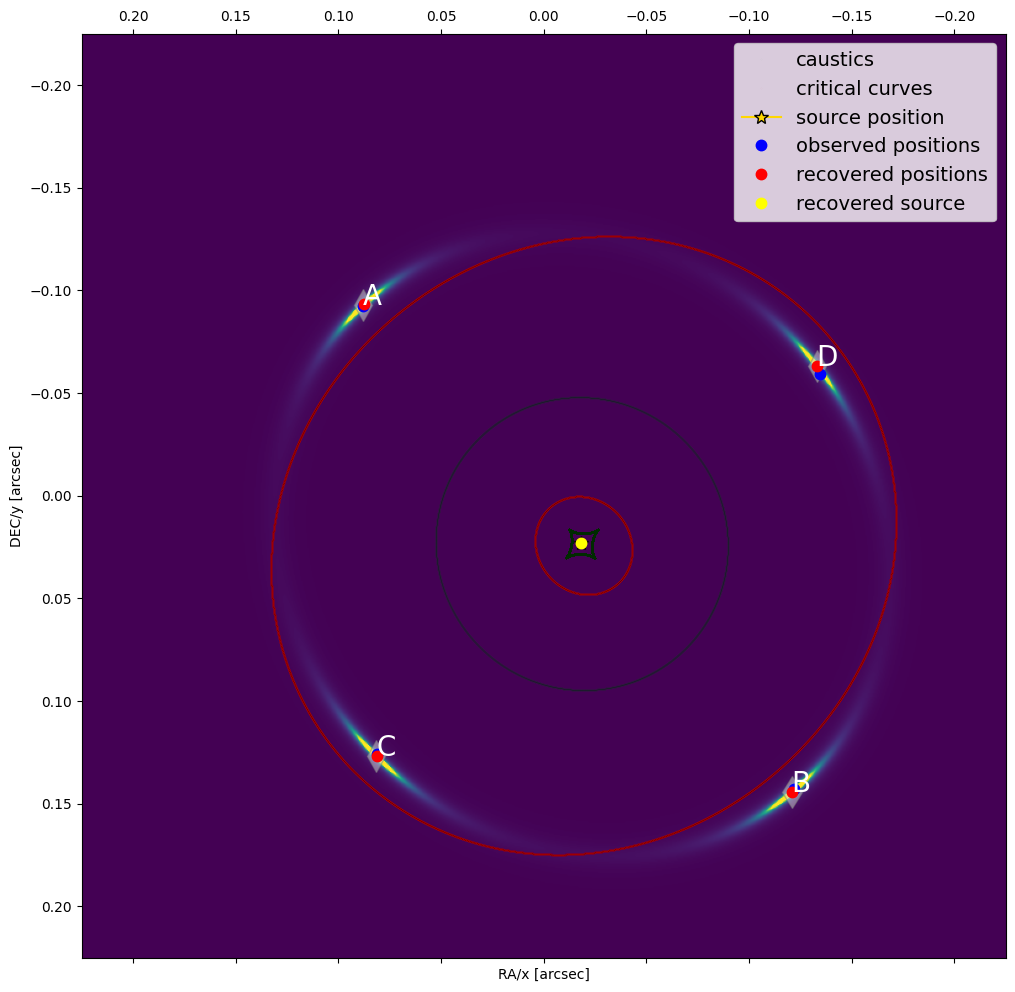


loss terms (in observed positions): tf.Tensor(
[[3.3002952e-04]
 [3.2144669e-04]
 [1.5580701e-04]
 [2.3808097e-05]
 [5.6653516e-05]
 [7.3648291e-05]], shape=(6, 1), dtype=float32)

flux ratios observed: tf.Tensor(
[[1.1979128]
 [1.0803423]
 [0.7711705]
 [0.9018539]
 [0.6437618]
 [0.7138205]], shape=(6, 1), dtype=float32)

flux ratios recovered (in observed positions): tf.Tensor(
[[1.3346971 ]
 [1.2135693 ]
 [0.83574635]
 [0.909247  ]
 [0.6261693 ]
 [0.688668  ]], shape=(6, 1), dtype=float32)
flux1/flux2: 11.42%
flux1/flux3: 12.33%
flux1/flux4: 8.37%
flux2/flux3: 0.82%
flux2/flux4: 2.73%
flux3/flux4: 3.52%

Predicted magnifications (in recovered positions). The ordering may have changed: tf.Tensor(
[[-19.035885]
 [ 22.05222 ]
 [-19.753315]
 [ 19.727709]], shape=(4, 1), dtype=float32)

Predicted magnifications (in observed positions): tf.Tensor(
[[ 20.358309]
 [-17.621803]
 [-18.480316]
 [ 22.269192]], shape=(4, 1), dtype=float32)


In [16]:
# other system
prior = tfd.JointDistributionSequential([lens_prior_uniform,])
prob_model_uniform = ForwardProbModel(prior, 0, background_rms=0.2, exp_time=100)

prior = tfd.JointDistributionSequential([lens_prior_trunc_normal,])
prob_model = ForwardProbModel(prior, 0, background_rms=0.2, exp_time=100)


delta_pix = 0.0006
num_pix = 750
truth_test = [[
        {'theta_E': 0.150, 'gamma': 1.9, 'e1': 0.029, 'e2': 0.053, 'center_x': -0.02, 'center_y': 0.025},
        {'gamma1': 0.012, 'gamma2': -0.025}
      ],
       [
        {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.005, 'Ie': 25.055}
    ],

               [
        {'center_x': -0.018, 'center_y': 0.024, 'Ie': 2815.973},
      ],]


analysis = LensModelAnalysis(delta_pix=delta_pix, num_pix=num_pix, weight_dist=500,weight_flux=500, truth_test=truth_test,
                             prob_model=prob_model, prior=prior,
                             # fixed
                             lens_prior = lens_prior, phys_model = phys_model,
                             prob_model_uniform=prob_model_uniform,
                             observed_data = None, simulation = True, flux_ratios = True)
analysis.run_map(lens_sim, n_map = 5000, n_steps = 3000)
analysis.run_vi()
samples_phys = analysis.run_hmc(n_hmc=50, num_burnin_steps=200, num_results=1000)